In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Load the dataset
train_images = np.load('C:/Users/rosmi/OneDrive/Desktop/Probs Model n Inference/k49-train-imgs.npz')['arr_0']
train_labels = np.load('C:/Users/rosmi/OneDrive/Desktop/Probs Model n Inference/k49-train-labels.npz')['arr_0']
test_images = np.load('C:/Users/rosmi/OneDrive/Desktop/Probs Model n Inference/k49-test-imgs.npz')['arr_0']
test_labels = np.load('C:/Users/rosmi/OneDrive/Desktop/Probs Model n Inference/k49-test-labels.npz')['arr_0']


In [3]:

# Normalize the images to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define a function for one-hot encoding using PyTorch
def to_one_hot(labels, num_classes):
    return torch.eye(num_classes)[labels]

# Convert labels to PyTorch tensors
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# One-hot encode the labels
num_classes = 49
train_labels_onehot = to_one_hot(train_labels_tensor, num_classes)
test_labels_onehot = to_one_hot(test_labels_tensor, num_classes)

# Convert images to PyTorch tensors and add a channel dimension
train_images_tensor = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
test_images_tensor = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1)  # Add channel dimension


In [4]:

# Define the C-VAE model
class CVAE(nn.Module):
    def __init__(self, image_size, label_size, hidden_dim, latent_dim):
        super(CVAE, self).__init__()
        self.fc1 = nn.Linear(image_size + label_size, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim + label_size, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, image_size)
    
    def encode(self, x, c):
        h = F.relu(self.fc1(torch.cat([x, c], dim=1)))
        return self.fc2_mean(h), self.fc2_logvar(h)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def decode(self, z, c):
        h = F.relu(self.fc3(torch.cat([z, c], dim=1)))
        return torch.sigmoid(self.fc4(h))
    
    def forward(self, x, c):
        mean, logvar = self.encode(x.view(-1, 28*28), c)
        z = self.reparameterize(mean, logvar)
        return self.decode(z, c), mean, logvar

# Create an instance of the C-VAE model
image_size = 28 * 28  # 28x28 images
label_size = 49  # 49 classes
hidden_dim = 256
latent_dim = 64
cvae = CVAE(image_size, label_size, hidden_dim, latent_dim)


In [9]:
# Create TensorDataset and DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(train_images_tensor, train_labels_onehot)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(test_images_tensor, test_labels_onehot)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cvae.to(device)

# Define the loss function
def loss_function(recon_x, x, mean, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(cvae.parameters(), lr=1e-3)

# Training loop with batching and GPU utilization
num_epochs = 10
for epoch in range(num_epochs):
    cvae.train()
    train_loss = 0
    for batch_idx, (img, lbl) in enumerate(train_loader):
        img = img.view(-1, 28*28).to(device)
        lbl = lbl.to(device)
        
        optimizer.zero_grad()
        recon_batch, mean, logvar = cvae(img, lbl)
        loss = loss_function(recon_batch, img, mean, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset)}')



Epoch 1, Loss: 202.77002612319922
Epoch 2, Loss: 191.65374632431062
Epoch 3, Loss: 188.4179657072386
Epoch 4, Loss: 186.75127405126364
Epoch 5, Loss: 185.66923583737466
Epoch 6, Loss: 184.90108433677216
Epoch 7, Loss: 184.32959002236512
Epoch 8, Loss: 183.83726406411384
Epoch 9, Loss: 183.4526029815027
Epoch 10, Loss: 183.1551782041118


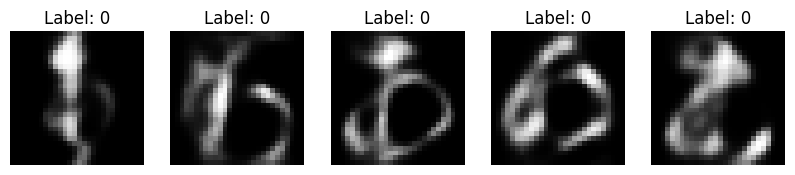

In [12]:
import matplotlib.pyplot as plt

# Function to generate new images and show the class label
def generate_and_show_images(cvae, num_samples, label):
    cvae.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        labels = torch.eye(num_classes)[torch.tensor([label] * num_samples)].to(device)
        generated_images = cvae.decode(z, labels).view(-1, 1, 28, 28).cpu()
    
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(generated_images[i, 0, :, :], cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()

# Generate and show 5 new images for a specific class (e.g., class 0)
generate_and_show_images(cvae, num_samples=5, label=0)


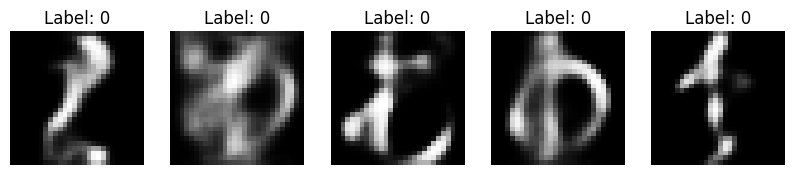

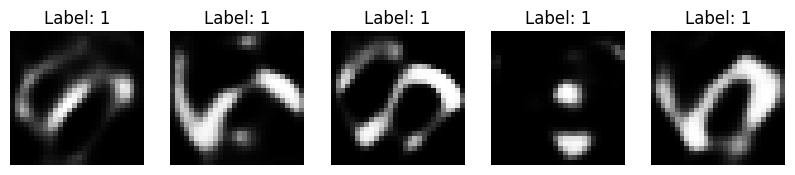

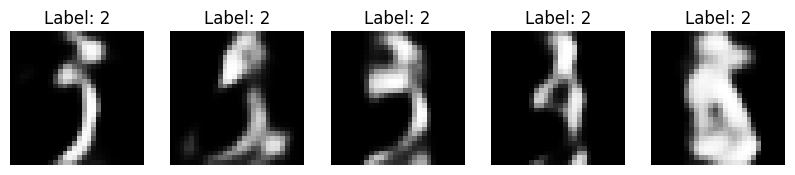

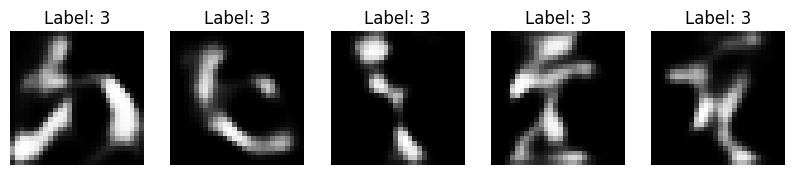

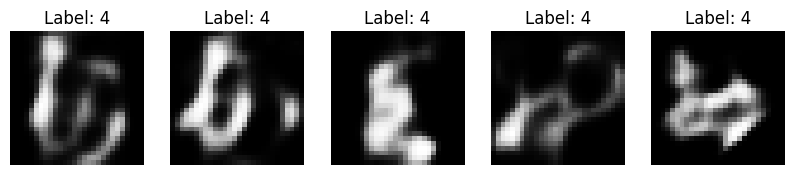

In [20]:
# Generate and show images for multiple classes
for label in range(5):  # Change range to generate for more labels
    generate_and_show_images(cvae, num_samples=5, label=label)
